In [1]:
import os
import time as timer
import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from torchvision import datasets
import torchvision.transforms as T

from joblib import dump, load

In [2]:
from autoencoder import MLPAutoEnc
import train_utils as tu
import visualization_utils as vu

## Define Constants

In [3]:
DATA_DIR = './data'
MODEL_DIR = './models'

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
dz = 300

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Load Data

In [4]:
training_data = load('./data/training_subdata.bin')
training_data

Dataset MNIST
    Number of datapoints: 5000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.ToTensor(), #convert to Tensor and normalize to (0, 1)
)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
"""
Create data loaders
"""
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

## Extract Encoder from Pre-trained Autoencoder

In [8]:
"""Load pre-trained autoencoder"""
print(f"Using {DEVICE} device")

# Define model
model = MLPAutoEnc(d_in=28*28, d_z=dz, d_h=512).to(DEVICE)

model_path = os.path.join(MODEL_DIR, "uns_ae_mnist.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cuda device
MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [9]:
pretrained_ae = copy.deepcopy(model)
pretrained_ae

MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## Define SSL with AE Model

In [10]:
classifier_layer = nn.Sequential(
    nn.ReLU(),
    nn.Linear(dz, 10)
)

pretrained_ae.add_module('classifier_layer', classifier_layer)

In [11]:
def forward(self, x):
    z = self.encoder(x)
    out = self.classifier_layer(z)
    return out

MLPAutoEnc.forward = forward

In [12]:
pretrained_ae

MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (classifier_layer): Sequential(
    (0): ReLU()
    (1): Linear(in_features=300, out_features=10, bias=True)
  )
)

# Train SSL AE Model

In [13]:
print(f"Using {DEVICE} device")

# Define model
pretrained_ae = pretrained_ae.to(DEVICE)
print(pretrained_ae)

# Persistent file to store the model
model_path = os.path.join(MODEL_DIR, "ssl_ae_v3_mnist.pth")

Using cuda device
MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (classifier_layer): Sequential(
    (0): ReLU()
    (1): Linear(in_features=300, out_features=10, bias=True)
  )
)


### Define the Loss Function and the Optimizer

In [14]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    pretrained_ae.parameters(), 
    lr=LEARNING_RATE
)

### Execute the Training

In [15]:
test_accuracy = []
train_accuracy = []
for t in range(EPOCHS):
    print(f"Epoch {t+1} out of {EPOCHS}\n ------------")
    
    start = timer.time()
    tu.train_ssl(train_dl, pretrained_ae, loss_fn, optimizer)
    elapsed_time = timer.time() - start # this timing method ONLY works for CPU computation, not for GPU/cuda calls
    print(f" > Training time: {elapsed_time:>.2f} seconds")
    
    print("Test Set Error:")
    acc_test = tu.test_ssl(test_dl, pretrained_ae, loss_fn)
    print("\nTrain Set Error:")
    acc_train = tu.test_ssl(train_dl, pretrained_ae, loss_fn)
    test_accuracy.append(acc_test)
    train_accuracy.append(acc_train)
    
    # Save model
    torch.save(pretrained_ae.state_dict(), model_path)
    print(f"Model {model_path} stored!")
    
print("Done!")

Epoch 1 out of 100
 ------------
Loss: 2.221887 [    0]/ 5000
Loss: 2.424855 [ 1600]/ 5000
Loss: 2.746436 [ 3200]/ 5000
Loss: 2.246474 [ 4800]/ 5000
 > Training time: 2.73 seconds
Test Set Error:
Test Error: 
 Accuracy: 20.3%, Avg loss: 2.210200 


Train Set Error:
Test Error: 
 Accuracy: 20.8%, Avg loss: 2.206481 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 2 out of 100
 ------------
Loss: 2.034950 [    0]/ 5000
Loss: 2.326062 [ 1600]/ 5000
Loss: 2.452725 [ 3200]/ 5000
Loss: 2.144955 [ 4800]/ 5000
 > Training time: 1.24 seconds
Test Set Error:
Test Error: 
 Accuracy: 31.9%, Avg loss: 2.101919 


Train Set Error:
Test Error: 
 Accuracy: 34.1%, Avg loss: 2.094815 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 3 out of 100
 ------------
Loss: 1.974352 [    0]/ 5000
Loss: 2.270127 [ 1600]/ 5000
Loss: 2.245557 [ 3200]/ 5000
Loss: 2.064793 [ 4800]/ 5000
 > Training time: 1.22 seconds
Test Set Error:
Test Error: 
 Accuracy: 42.8%, Avg loss: 1.992263 


Train Set Error:
Test Error: 

Test Error: 
 Accuracy: 84.1%, Avg loss: 0.596148 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 24 out of 100
 ------------
Loss: 0.413186 [    0]/ 5000
Loss: 1.143253 [ 1600]/ 5000
Loss: 0.407871 [ 3200]/ 5000
Loss: 0.689710 [ 4800]/ 5000
 > Training time: 1.42 seconds
Test Set Error:
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.623286 


Train Set Error:
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.576210 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 25 out of 100
 ------------
Loss: 0.394395 [    0]/ 5000
Loss: 1.121607 [ 1600]/ 5000
Loss: 0.391414 [ 3200]/ 5000
Loss: 0.662180 [ 4800]/ 5000
 > Training time: 1.30 seconds
Test Set Error:
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.605776 


Train Set Error:
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.557730 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 26 out of 100
 ------------
Loss: 0.377143 [    0]/ 5000
Loss: 1.101252 [ 1600]/ 5000
Loss: 0.376341 [ 3200]/ 5000
Loss: 0.636327 [ 4800]/ 5000
 > Training time: 1.36 seconds


Test Error: 
 Accuracy: 87.5%, Avg loss: 0.409011 


Train Set Error:
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.343001 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 47 out of 100
 ------------
Loss: 0.166345 [    0]/ 5000
Loss: 0.760090 [ 1600]/ 5000
Loss: 0.221257 [ 3200]/ 5000
Loss: 0.337790 [ 4800]/ 5000
 > Training time: 1.32 seconds
Test Set Error:
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.403974 


Train Set Error:
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.337111 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 48 out of 100
 ------------
Loss: 0.160236 [    0]/ 5000
Loss: 0.748656 [ 1600]/ 5000
Loss: 0.217382 [ 3200]/ 5000
Loss: 0.329823 [ 4800]/ 5000
 > Training time: 1.21 seconds
Test Set Error:
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.399079 


Train Set Error:
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.331375 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 49 out of 100
 ------------
Loss: 0.154485 [    0]/ 5000
Loss: 0.737510 [ 1600]/ 5000
Loss: 0.213763 [ 32

Loss: 0.160673 [ 3200]/ 5000
Loss: 0.220609 [ 4800]/ 5000
 > Training time: 1.20 seconds
Test Set Error:
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.328997 


Train Set Error:
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.243354 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 70 out of 100
 ------------
Loss: 0.075035 [    0]/ 5000
Loss: 0.551777 [ 1600]/ 5000
Loss: 0.158716 [ 3200]/ 5000
Loss: 0.217148 [ 4800]/ 5000
 > Training time: 1.16 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.326657 


Train Set Error:
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.240153 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 71 out of 100
 ------------
Loss: 0.072736 [    0]/ 5000
Loss: 0.545146 [ 1600]/ 5000
Loss: 0.156832 [ 3200]/ 5000
Loss: 0.213711 [ 4800]/ 5000
 > Training time: 1.15 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.324419 


Train Set Error:
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.237048 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 

Loss: 0.429648 [ 1600]/ 5000
Loss: 0.127578 [ 3200]/ 5000
Loss: 0.157392 [ 4800]/ 5000
 > Training time: 1.27 seconds
Test Set Error:
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.288254 


Train Set Error:
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.182615 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 93 out of 100
 ------------
Loss: 0.040904 [    0]/ 5000
Loss: 0.424922 [ 1600]/ 5000
Loss: 0.126297 [ 3200]/ 5000
Loss: 0.155341 [ 4800]/ 5000
 > Training time: 1.21 seconds
Test Set Error:
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.286919 


Train Set Error:
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.180425 

Model ./models\ssl_ae_v3_mnist.pth stored!
Epoch 94 out of 100
 ------------
Loss: 0.040068 [    0]/ 5000
Loss: 0.420575 [ 1600]/ 5000
Loss: 0.125095 [ 3200]/ 5000
Loss: 0.153244 [ 4800]/ 5000
 > Training time: 1.23 seconds
Test Set Error:
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.285631 


Train Set Error:
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.178278 

Model ./models\ssl_a

## Accuracy Plot

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Plotting Helper Function
def plot_acc_epoch(epochs, train_acc, test_acc):
    l = range(1,epochs+1)
    N = len(l)
    l2 = np.arange(N)
    plt.subplots(figsize=(10, 5))
    plt.plot(l2, test_acc, label="Testing Accuracy")
    plt.plot(l2, train_acc, label="Training Accuracy")
#     plt.xticks(l2,l)
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title('Accuracy versus Epoch SSL with AE Model', fontsize=12)
    plt.show()

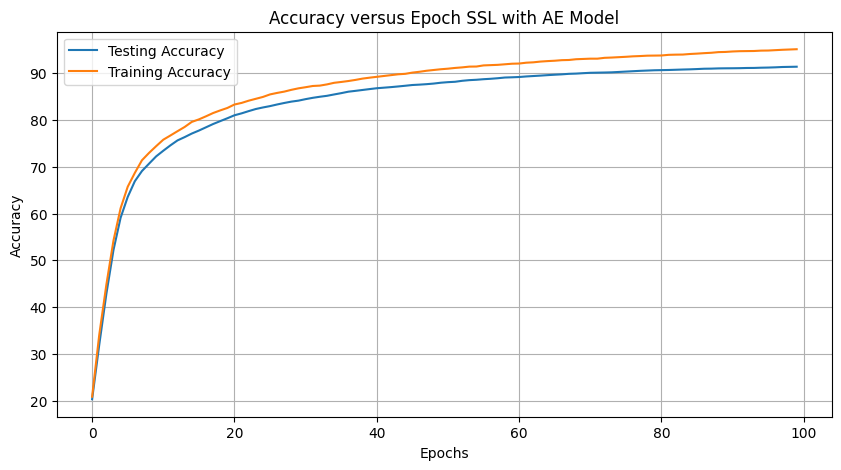

In [22]:
plot_acc_epoch(100, train_accuracy, test_accuracy)

In [19]:
max(train_accuracy), max(test_accuracy)

(95.12, 91.38)

In [20]:
train_accuracy[-1], test_accuracy[-1]

(95.12, 91.38)